In [129]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data.dataloader import DataLoader

from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from torchvision.transforms import Compose
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
import json
import math
import random

## Limiting randomness
https://pytorch.org/docs/stable/notes/randomness.html

In [8]:
random_seed = 42 # for custom operators

torch.manual_seed(random_seed) # for torch
np.random.seed(random_seed) # for NumPy libraries

# Use deterministic algorithms only
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.use_deterministic_algorithms(True)

# Use deterministric convolution algorithm in CUDA
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [9]:
# Fix workers randomness
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(random_seed)

## General

In [ ]:
#https://github.com/sujitpal/deeplearning-ai-examples/blob/master/tricks01_cifar10.ipynb
#https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch


In [10]:
data_dir = '~/cifar10_data/cifar10'

In [100]:
model_dir = '~/cifar10_data/cifar10/model/'
model_dir = os.path.expanduser(model_dir)

## Datasets Load

In [19]:
train_ds = torchvision.datasets.CIFAR10(data_dir+'/train',
                                        transform=Compose([
                                            transforms.ToTensor()                      
                                        ]),
                                        train=True, download=True)

test_ds = torchvision.datasets.CIFAR10(data_dir+'/test', 
                                       transform=Compose([
                                           transforms.ToTensor()
                                         ]),
                                       train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
len(train_ds), len(test_ds)

(50000, 10000)

### Normalization 1

In [18]:
norm_mean = np.round(train_ds.data.mean(axis=(0, 1, 2)) / 255, 4).tolist() 
norm_std = np.round(train_ds.data.std(axis=(0, 1, 2)) / 255, 4).tolist()

norm_mean, norm_std

([0.4914, 0.4822, 0.4465], [0.247, 0.2435, 0.2616])

In [20]:
train_ds_norm_1 = torchvision.datasets.CIFAR10(data_dir+'/train',
                                        transform=Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=norm_mean, std=norm_std)
                                        ]),
                                        train=True, download=True)
test_ds_norm_1 = torchvision.datasets.CIFAR10(data_dir+'/test', 
                                       transform=Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=norm_mean, std=norm_std)
                                       ]),
                                       train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


### Normalization 2

In [21]:
train_ds_norm_2 = torchvision.datasets.CIFAR10(data_dir+'/train',
                                        transform=Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize([0, 0, 0], [1, 1, 1])
                                        ]),
                                        train=True, download=True)
test_ds_norm_2 = torchvision.datasets.CIFAR10(data_dir+'/test', 
                                       transform=Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize([0, 0, 0], [1, 1, 1])
                                       ]),
                                       train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


### Normalization 1 + Augmanation

In [22]:
train_ds_norm_1_aug = torchvision.datasets.CIFAR10(data_dir+'/train',
                                        transform=Compose([
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.RandomCrop(32, padding=4),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=norm_mean, std=norm_std)
                                        ]),
                                        train=True, download=True)


Files already downloaded and verified


### Normalization 2 + Augmanation

In [23]:
train_ds_norm_2_aug = torchvision.datasets.CIFAR10(data_dir+'/train',
                                        transform=Compose([
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.RandomCrop(32, padding=4),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0, 0, 0], [1, 1, 1])
                                        ]),
                                        train=True, download=True)

Files already downloaded and verified


## Train/Validation random split

In [24]:
val_size = 5000
train_size = len(train_ds) - val_size
train_size

45000

In [27]:
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
train_ds_norm_1, val_ds_norm_1 = random_split(train_ds_norm_1, [train_size, val_size])
train_ds_norm_2, val_ds_norm_2 = random_split(train_ds_norm_2, [train_size, val_size])
train_ds_norm_1_aug, val_ds_norm_1_aug = random_split(train_ds_norm_1_aug, [train_size, val_size])
train_ds_norm_2_aug, val_ds_norm_2_aug = random_split(train_ds_norm_2_aug, [train_size, val_size])

In [28]:
print('len(train_ds), len(val_ds) = ', len(train_ds), len(val_ds))
print('len(train_ds_norm_1), len(val_ds_norm_1) = ', len(train_ds_norm_1), len(val_ds_norm_1))
print('len(train_ds_norm_2), len(val_ds_norm_2) = ', len(train_ds_norm_2), len(val_ds_norm_2))
print('len(train_ds_norm_1_aug), len(val_ds_norm_1_aug) = ', len(train_ds_norm_1_aug), len(val_ds_norm_1_aug))
print('len(train_ds_norm_2_aug), len(val_ds_norm_2_aug) = ', len(train_ds_norm_2_aug), len(val_ds_norm_2_aug))

len(train_ds), len(val_ds) =  45000 5000
len(train_ds_norm_1), len(val_ds_norm_1) =  45000 5000
len(train_ds_norm_2), len(val_ds_norm_2) =  45000 5000
len(train_ds_norm_1_aug), len(val_ds_norm_1_aug) =  45000 5000
len(train_ds_norm_2_aug), len(val_ds_norm_2_aug) =  45000 5000


## DataLoader

During validation, you typically don't need to compute gradients, 
so you can afford to use a larger batch size without worrying about GPU memory limitations

In [29]:
batch_size=128

In [34]:
def dataloader_help(train_ds, val_ds):
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True, generator=g, worker_init_fn=seed_worker)
    val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True, generator=g, worker_init_fn=seed_worker)
    return train_dl, val_dl

In [35]:
train_dl, val_dl = dataloader_help(train_ds, val_ds)
train_dl_norm_1, val_dl_norm_1 = dataloader_help(train_ds_norm_1, val_ds_norm_1)
train_dl_norm_2, val_dl_norm_2 = dataloader_help(train_ds_norm_2, val_ds_norm_2)
train_dl_norm_1_aug, val_dl_norm_1_aug = dataloader_help(train_ds_norm_1_aug, val_ds_norm_1_aug)
train_dl_norm_2_aug, val_dl_norm_2_aug = dataloader_help(train_ds_norm_2_aug, val_ds_norm_2_aug)

In [36]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

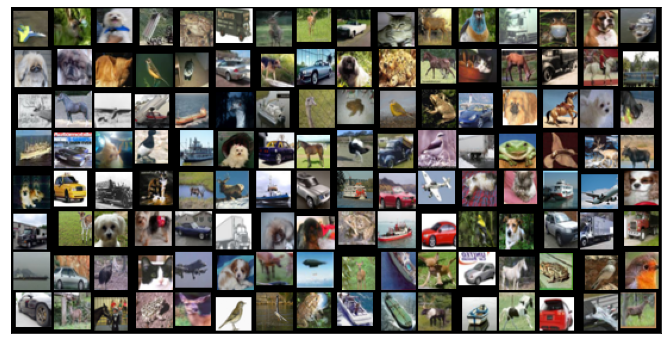

In [42]:
show_batch(train_dl_norm_2_aug)

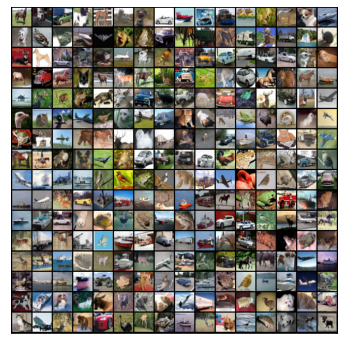

In [38]:
show_batch(val_dl)

In [50]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0376,  0.0156, -0.0132, -0.0253,  0.0250, -0.0059, -0.0324, -0.0426,
         0.0174, -0.0103], grad_fn=<SelectBackward0>)


## Device

In [53]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
################################################################        
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
################################################################
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [54]:
device = get_default_device()
device

device(type='cuda')

## To_device

In [55]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

train_dl_norm_1 = DeviceDataLoader(train_dl_norm_1, device)
val_dl_norm_1 = DeviceDataLoader(val_dl_norm_1, device)

train_dl_norm_2 = DeviceDataLoader(train_dl_norm_2, device)
val_dl_norm_2 = DeviceDataLoader(val_dl_norm_2, device)

train_dl_norm_1_aug = DeviceDataLoader(train_dl_norm_1_aug, device)
val_dl_norm_1_aug = DeviceDataLoader(val_dl_norm_1_aug, device)

train_dl_norm_2_aug = DeviceDataLoader(train_dl_norm_2_aug, device)
val_dl_norm_2_aug = DeviceDataLoader(val_dl_norm_2_aug, device)

## Image Classification Base

In [44]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Model

In [45]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [49]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

## Fit

In [61]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
##################################################################################

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [56]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [57]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

## Hyperparameters

In [58]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

## Train

In [59]:
model = to_device(Cifar10CnnModel(), device)
model_reproducability = to_device(Cifar10CnnModel(), device)
model_norm_1 = to_device(Cifar10CnnModel(), device)
model_norm_2 = to_device(Cifar10CnnModel(), device)
model_norm_1_aug = to_device(Cifar10CnnModel(), device)
model_norm_2_aug = to_device(Cifar10CnnModel(), device)

In [62]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7903, val_loss: 1.4090, val_acc: 0.4820
Epoch [1], train_loss: 1.2289, val_loss: 1.0476, val_acc: 0.6167
Epoch [2], train_loss: 0.9534, val_loss: 0.8879, val_acc: 0.6829
Epoch [3], train_loss: 0.7718, val_loss: 0.7495, val_acc: 0.7365
Epoch [4], train_loss: 0.6393, val_loss: 0.7192, val_acc: 0.7489
Epoch [5], train_loss: 0.5120, val_loss: 0.7068, val_acc: 0.7574
Epoch [6], train_loss: 0.4083, val_loss: 0.6923, val_acc: 0.7767
Epoch [7], train_loss: 0.3135, val_loss: 0.7306, val_acc: 0.7710
Epoch [8], train_loss: 0.2397, val_loss: 0.8349, val_acc: 0.7658
Epoch [9], train_loss: 0.1777, val_loss: 0.8630, val_acc: 0.7740


In [63]:
history_reproducability = fit(num_epochs, lr, model_reproducability, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8113, val_loss: 1.4570, val_acc: 0.4546
Epoch [1], train_loss: 1.2960, val_loss: 1.1803, val_acc: 0.5708
Epoch [2], train_loss: 1.0212, val_loss: 0.9462, val_acc: 0.6647
Epoch [3], train_loss: 0.8168, val_loss: 0.8018, val_acc: 0.7198
Epoch [4], train_loss: 0.6655, val_loss: 0.7279, val_acc: 0.7433
Epoch [5], train_loss: 0.5406, val_loss: 0.6995, val_acc: 0.7593
Epoch [6], train_loss: 0.4318, val_loss: 0.7246, val_acc: 0.7522
Epoch [7], train_loss: 0.3330, val_loss: 0.7305, val_acc: 0.7748
Epoch [8], train_loss: 0.2391, val_loss: 0.7881, val_acc: 0.7759
Epoch [9], train_loss: 0.1757, val_loss: 0.8959, val_acc: 0.7753


In [64]:
history_norm_1 = fit(num_epochs, lr, model_norm_1, train_dl_norm_1, val_dl_norm_1, opt_func)

Epoch [0], train_loss: 1.6123, val_loss: 1.2171, val_acc: 0.5567
Epoch [1], train_loss: 1.0404, val_loss: 0.8609, val_acc: 0.6974
Epoch [2], train_loss: 0.7628, val_loss: 0.7332, val_acc: 0.7430
Epoch [3], train_loss: 0.5912, val_loss: 0.6658, val_acc: 0.7674
Epoch [4], train_loss: 0.4599, val_loss: 0.6425, val_acc: 0.7851
Epoch [5], train_loss: 0.3470, val_loss: 0.6531, val_acc: 0.7933
Epoch [6], train_loss: 0.2609, val_loss: 0.7406, val_acc: 0.7913
Epoch [7], train_loss: 0.1905, val_loss: 0.7590, val_acc: 0.7956
Epoch [8], train_loss: 0.1352, val_loss: 0.8635, val_acc: 0.7945
Epoch [9], train_loss: 0.1227, val_loss: 0.9697, val_acc: 0.7810


In [65]:
history_norm_2 = fit(num_epochs, lr, model_norm_2, train_dl_norm_2, val_dl_norm_2, opt_func)

Epoch [0], train_loss: 1.9402, val_loss: 1.6268, val_acc: 0.3937
Epoch [1], train_loss: 1.4329, val_loss: 1.3567, val_acc: 0.5077
Epoch [2], train_loss: 1.1678, val_loss: 1.1280, val_acc: 0.6055
Epoch [3], train_loss: 0.9449, val_loss: 1.0101, val_acc: 0.6508
Epoch [4], train_loss: 0.7995, val_loss: 0.8750, val_acc: 0.6933
Epoch [5], train_loss: 0.6858, val_loss: 0.8202, val_acc: 0.7170
Epoch [6], train_loss: 0.5760, val_loss: 0.7999, val_acc: 0.7234
Epoch [7], train_loss: 0.4799, val_loss: 0.8485, val_acc: 0.7253
Epoch [8], train_loss: 0.4014, val_loss: 0.8777, val_acc: 0.7429
Epoch [9], train_loss: 0.3166, val_loss: 0.9882, val_acc: 0.7241


In [66]:
history_norm_1_aug = fit(num_epochs, lr, model_norm_1_aug, train_dl_norm_1_aug, val_dl_norm_1_aug, opt_func)

Epoch [0], train_loss: 1.7429, val_loss: 1.4431, val_acc: 0.4544
Epoch [1], train_loss: 1.2463, val_loss: 1.1111, val_acc: 0.6011
Epoch [2], train_loss: 0.9917, val_loss: 1.0548, val_acc: 0.6223
Epoch [3], train_loss: 0.8274, val_loss: 0.8220, val_acc: 0.7040
Epoch [4], train_loss: 0.7324, val_loss: 0.7464, val_acc: 0.7398
Epoch [5], train_loss: 0.6599, val_loss: 0.7434, val_acc: 0.7373
Epoch [6], train_loss: 0.5979, val_loss: 0.6384, val_acc: 0.7796
Epoch [7], train_loss: 0.5488, val_loss: 0.6102, val_acc: 0.7955
Epoch [8], train_loss: 0.5148, val_loss: 0.6011, val_acc: 0.7910
Epoch [9], train_loss: 0.4804, val_loss: 0.5981, val_acc: 0.8023


In [67]:
history_norm_2_aug = fit(num_epochs, lr, model_norm_2_aug, train_dl_norm_2_aug, val_dl_norm_2_aug, opt_func)

Epoch [0], train_loss: 1.8364, val_loss: 1.5072, val_acc: 0.4467
Epoch [1], train_loss: 1.3534, val_loss: 1.2168, val_acc: 0.5475
Epoch [2], train_loss: 1.1204, val_loss: 1.0931, val_acc: 0.6097
Epoch [3], train_loss: 0.9807, val_loss: 0.9077, val_acc: 0.6776
Epoch [4], train_loss: 0.8757, val_loss: 0.8468, val_acc: 0.7027
Epoch [5], train_loss: 0.7821, val_loss: 0.8055, val_acc: 0.7195
Epoch [6], train_loss: 0.7164, val_loss: 0.7293, val_acc: 0.7495
Epoch [7], train_loss: 0.6623, val_loss: 0.6587, val_acc: 0.7718
Epoch [8], train_loss: 0.6166, val_loss: 0.6449, val_acc: 0.7729
Epoch [9], train_loss: 0.5881, val_loss: 0.6108, val_acc: 0.7946


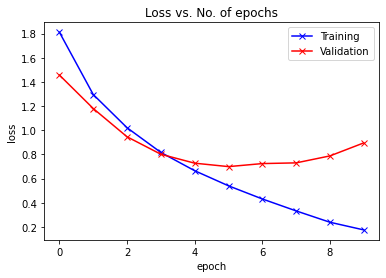

In [68]:
plot_losses(history)

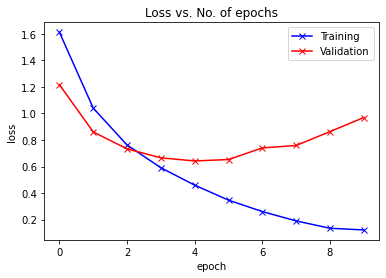

In [69]:
plot_losses(history_norm_1)

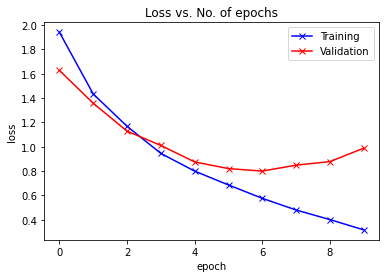

In [70]:
plot_losses(history_norm_2)

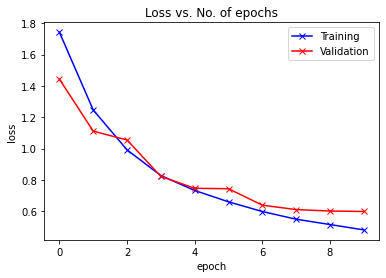

In [71]:
plot_losses(history_norm_1_aug)

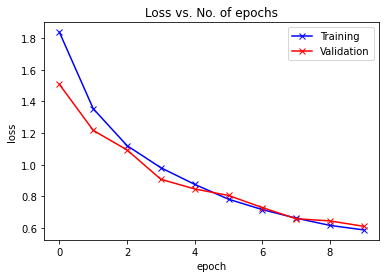

In [72]:
plot_losses(history_norm_2_aug)

## Test set evaluation

In [74]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
test_dl_norm_1 = DeviceDataLoader(DataLoader(test_ds_norm_1, batch_size*2), device)
test_dl_norm_2 = DeviceDataLoader(DataLoader(test_ds_norm_2, batch_size*2), device)

In [76]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.9619762301445007, 'val_acc': 0.7650390863418579}

In [77]:
result_norm_1 = evaluate(model_norm_1, test_dl_norm_1)
result_norm_1

{'val_loss': 1.0042160749435425, 'val_acc': 0.7802734375}

In [78]:
result_norm_2 = evaluate(model_norm_2, test_dl_norm_2)
result_norm_2

{'val_loss': 0.9921302795410156, 'val_acc': 0.7191406488418579}

In [79]:
result_norm_1_aug = evaluate(model_norm_1_aug, test_dl_norm_1)
result_norm_1_aug

{'val_loss': 0.5471593737602234, 'val_acc': 0.8194335699081421}

In [81]:
result_norm_2_aug = evaluate(model_norm_2_aug, test_dl_norm_2)
result_norm_2_aug

{'val_loss': 0.6045225262641907, 'val_acc': 0.7930663824081421}

In [83]:
CIFAR10_LABELS = [
  "aircraft", "automobile", "bird", "cat", "deer", 
  "dog", "frog", "horse", "ship", "truck"
]
idx2label = {i:x for i, x in enumerate(CIFAR10_LABELS)}
label2idx = {v:k for k, v in idx2label.items()}

len(idx2label), len(label2idx)

(10, 10)

In [88]:
def evaluate(model, test_dl):
  model.eval()
  true_values, pred_values = [], []
    
  for batch in test_dl:
    images, labels = batch
    images = images.to(device)

    with torch.no_grad():
      logits = model(images)
        
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    true_values.extend(labels.tolist())
    pred_values.extend(preds.tolist())

  return true_values, pred_values

In [92]:
def write_metrics(true_values, pred_values, experiment_name, metric_filepath):
  fout = open(metric_filepath, "w")
  p, r, f, s = precision_recall_fscore_support(true_values, pred_values, average="micro")
  metrics_dict = {
    "precision": p, "recall": r, "f1-score": f, "support": s
  }
  metrics_dict["name"] = experiment_name
  fout.write(json.dumps(metrics_dict))
  fout.close()

In [95]:
model_dir

'~/cifar10_data/cifar10/model/'

In [96]:
model_dir = os.path.expanduser(model_dir)
model_dir

'/home/projects/bagon/ingap/cifar10_data/cifar10/model/'

In [109]:
def evaluate_summary(model, test_dl, experiment_name, file_name):
    true_values, pred_values = evaluate(model, test_dl)

    # print results
    print("** accuracy: {:.3f}".format(accuracy_score(true_values, pred_values)))
    print("--")
    print("confusion matrix")
    print(confusion_matrix(true_values, pred_values))
    print("--")
    print("classification report")
    print(classification_report(true_values, pred_values, target_names=CIFAR10_LABELS))

    # save results
    metric_filepath = os.path.join(model_dir, file_name)
    write_metrics(true_values, pred_values, experiment_name, metric_filepath)

In [112]:
file_name = "model.json"
experiment_name = "baseline"
evaluate_summary(model, test_dl, experiment_name, file_name)

** accuracy: 0.764
--
confusion matrix
[[834   9  44  16  15   6   5   5  42  24]
 [ 18 860   2  10   2   3   1   1  30  73]
 [ 69   4 709  45  59  42  39  21   8   4]
 [ 21   2  79 541  56 196  49  31  16   9]
 [ 20   1  84  44 740  52  14  37   5   3]
 [ 13   2  63 134  39 706  11  29   2   1]
 [  4   2  64  60  56  20 781   3   7   3]
 [ 13   3  36  42  55  66   1 776   4   4]
 [ 72  12  18  10   6   1   6   3 857  15]
 [ 32  44  13  22   6   6   6  17  19 835]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.76      0.83      0.80      1000
  automobile       0.92      0.86      0.89      1000
        bird       0.64      0.71      0.67      1000
         cat       0.59      0.54      0.56      1000
        deer       0.72      0.74      0.73      1000
         dog       0.64      0.71      0.67      1000
        frog       0.86      0.78      0.82      1000
       horse       0.84      0.78      0.81      1000
        ship      

In [113]:
file_name = "model_norm_1.json"
experiment_name = "norm_1"
evaluate_summary(model_norm_1, test_dl_norm_1, experiment_name, file_name)

** accuracy: 0.778
--
confusion matrix
[[829  13  48  21   7   4   4   2  57  15]
 [  9 922   5   4   2   3   3   0  17  35]
 [ 57   2 731  53  31  41  54   6  19   6]
 [ 19   5  64 681  32 109  60  10  13   7]
 [ 24   3  94  94 661  36  65  14   6   3]
 [  3   6  51 194  18 697  12  15   2   2]
 [  5   5  51  53  13  15 840   3  10   5]
 [ 23   5  31  56  75  88   5 698   4  15]
 [ 37  17  10  10   1   3   2   1 906  13]
 [ 39  88   6  25   1   2   3   3  18 815]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.79      0.83      0.81      1000
  automobile       0.86      0.92      0.89      1000
        bird       0.67      0.73      0.70      1000
         cat       0.57      0.68      0.62      1000
        deer       0.79      0.66      0.72      1000
         dog       0.70      0.70      0.70      1000
        frog       0.80      0.84      0.82      1000
       horse       0.93      0.70      0.80      1000
        ship      

In [114]:
file_name = "model_norm_2.json"
experiment_name = "norm_2"
evaluate_summary(model_norm_2, test_dl_norm_2, experiment_name, file_name)

** accuracy: 0.721
--
confusion matrix
[[820   6  46  29  22   8  11  10  29  19]
 [ 26 837  14  15   7   5  21   1  17  57]
 [ 74   1 581 104  67  62  58  40   9   4]
 [ 20   3  60 611  49 160  52  25  12   8]
 [ 20   1  82 102 629  37  58  68   2   1]
 [ 12   2  33 204  45 630  21  48   1   4]
 [ 11   5  47  87  28  34 774   5   7   2]
 [ 17   0  20  46  51  65   7 786   2   6]
 [137  32  14  27  12   5  12   7 736  18]
 [ 53  51   6  24  10   5  14  12  15 810]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.69      0.82      0.75      1000
  automobile       0.89      0.84      0.86      1000
        bird       0.64      0.58      0.61      1000
         cat       0.49      0.61      0.54      1000
        deer       0.68      0.63      0.66      1000
         dog       0.62      0.63      0.63      1000
        frog       0.75      0.77      0.76      1000
       horse       0.78      0.79      0.79      1000
        ship      

In [115]:
file_name = "model_norm_1_aug.json"
experiment_name = "norm_1_aug"
evaluate_summary(model_norm_1_aug, test_dl_norm_1, experiment_name, file_name)

** accuracy: 0.818
--
confusion matrix
[[754   4  84  21  35   2  10  13  62  15]
 [  6 890   1   2   3   2  14   3  19  60]
 [ 17   0 767  22  75  49  47  18   4   1]
 [  5   0  46 588  88 174  62  31   2   4]
 [  2   0  35  24 861  20  25  33   0   0]
 [  1   0  42  75  47 797  14  23   1   0]
 [  4   0  39  20  25  15 892   4   1   0]
 [  7   1  20  23  54  46   3 843   2   1]
 [ 34  10  13  11   7   3   8   2 900  12]
 [ 19  36   5   9   4   3   5   4  26 889]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.89      0.75      0.82      1000
  automobile       0.95      0.89      0.92      1000
        bird       0.73      0.77      0.75      1000
         cat       0.74      0.59      0.66      1000
        deer       0.72      0.86      0.78      1000
         dog       0.72      0.80      0.76      1000
        frog       0.83      0.89      0.86      1000
       horse       0.87      0.84      0.85      1000
        ship      

In [116]:
file_name = "model_norm_2_aug.json"
experiment_name = "norm_2_aug"
evaluate_summary(model_norm_2_aug, test_dl_norm_2, experiment_name, file_name)

** accuracy: 0.791
--
confusion matrix
[[811  20  60   4  15   1   7   6  60  16]
 [ 14 935   3   3   2   0   3   0  11  29]
 [ 61   3 784  22  49  33  26  11   6   5]
 [ 22  13 134 552  58 122  61  21   6  11]
 [ 17   2  78  28 782  15  26  43   4   5]
 [  8   2  95 121  43 679  13  35   1   3]
 [  8   4  92  27  39  13 810   4   2   1]
 [ 19   2  57  20  35  34   2 820   2   9]
 [ 43  17   8  13   4   0   3   3 899  10]
 [ 30  88   7   7   4   2   2   2  19 839]]
--
classification report
              precision    recall  f1-score   support

    aircraft       0.79      0.81      0.80      1000
  automobile       0.86      0.94      0.90      1000
        bird       0.59      0.78      0.68      1000
         cat       0.69      0.55      0.61      1000
        deer       0.76      0.78      0.77      1000
         dog       0.76      0.68      0.72      1000
        frog       0.85      0.81      0.83      1000
       horse       0.87      0.82      0.84      1000
        ship      

## Model comparisons

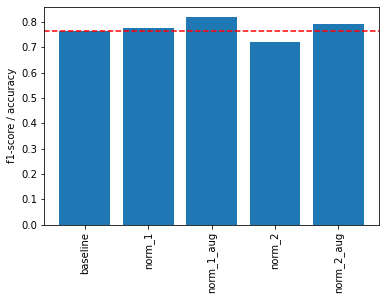

In [118]:
json_files = []
for f in os.listdir(model_dir):
  if f.endswith(".json"):
    json_files.append(f)

xs, ps, rs, fs = [], [], [], []
for json_file in sorted(json_files):
  with open(os.path.join(model_dir, json_file), "r") as f:
    metrics_dict = json.loads(f.read())
    xs.append(metrics_dict["name"])
    ps.append(metrics_dict["precision"])
    rs.append(metrics_dict["recall"])
    fs.append(metrics_dict["f1-score"])

plt.bar(np.arange(len(fs)), fs)
plt.ylabel("f1-score / accuracy")
plt.xticks(np.arange(len(fs)), xs, rotation="90")
plt.axhline(fs[0], 0, len(fs), color="r", linestyle="--")
_ = plt.show()

## Visualize test predictions

In [123]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_ds.classes[preds[0].item()]

## Incorrect predictions

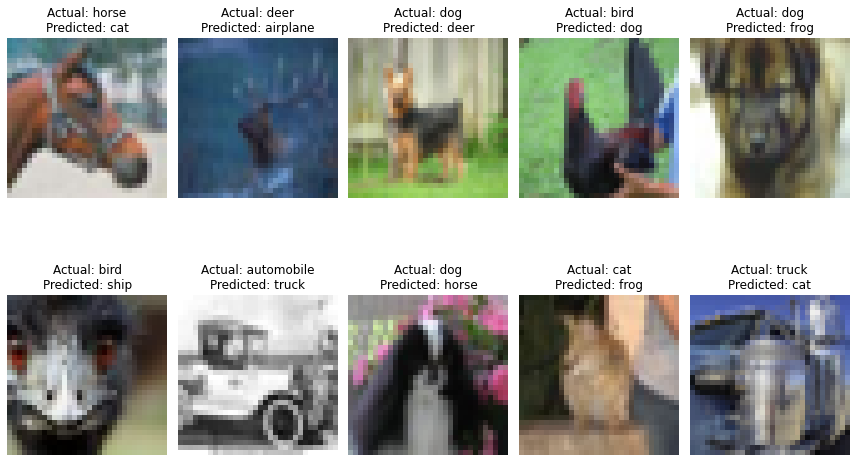

In [131]:
# Counter to keep track of displayed mismatched images
displayed_count = 0

# Calculate number of rows and columns for the subplot grid
num_images = 10  # Number of mismatched images to display
num_cols = 5     # Number of columns in the grid
num_rows = math.ceil(num_images / num_cols)

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Iterate through the test dataset
for index in range(len(test_ds)):
    img, label = test_ds[index]
    predicted_label = predict_image(img, model)
    
    # Check if prediction does not match the actual label
    if predicted_label != test_ds.classes[label]:
        # Plot the image in the next available subplot
        ax = axs[displayed_count // num_cols, displayed_count % num_cols]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(f"Actual: {test_ds.classes[label]}\nPredicted: {predicted_label}")
        ax.axis('off')
        
        # Increment the counter
        displayed_count += 1
        
        # Break the loop if all desired images have been displayed
        if displayed_count == num_images:
            break

# Hide any remaining empty subplots
for i in range(displayed_count, num_rows * num_cols):
    axs[i // num_cols, i % num_cols].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Correct predictions

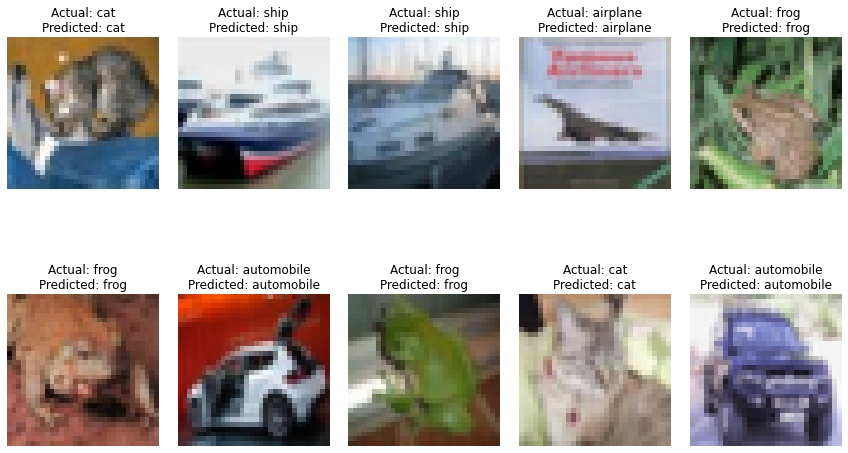

In [136]:
# Counter to keep track of displayed mismatched images
displayed_count = 0

# Calculate number of rows and columns for the subplot grid
num_images = 10  # Number of mismatched images to display
num_cols = 5     # Number of columns in the grid
num_rows = math.ceil(num_images / num_cols)

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Iterate through the test dataset
for index in range(len(test_ds)):
    img, label = test_ds[index]
    predicted_label = predict_image(img, model)
    
    # Check if prediction does not match the actual label
    if predicted_label == test_ds.classes[label]:
        # Plot the image in the next available subplot
        ax = axs[displayed_count // num_cols, displayed_count % num_cols]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(f"Actual: {test_ds.classes[label]}\nPredicted: {predicted_label}")
        ax.axis('off')
        
        # Increment the counter
        displayed_count += 1
        
        # Break the loop if all desired images have been displayed
        if displayed_count == num_images:
            break

# Hide any remaining empty subplots
for i in range(displayed_count, num_rows * num_cols):
    axs[i // num_cols, i % num_cols].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()